<a href="https://colab.research.google.com/github/nandhukumar86/GL-hackathons-1/blob/main/GL_hackathon_1_Nandha_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Basic Imports

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline


# Load the dataset

In [ ]:
fd_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/frequency_domain_features_train.csv')
fd_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/frequency_domain_features_test.csv')
td_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/time_domain_features_train.csv')
td_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/time_domain_features_test.csv')
hr_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/heart_rate_non_linear_features_train.csv')
hr_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/heart_rate_non_linear_features_test.csv')

In [189]:
fd_train.shape, fd_test.shape

((369289, 12), (41033, 12))

In [190]:
fd_train.columns, fd_test.columns

(Index(['uuid', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT',
        'HF_NU', 'TP', 'LF_HF', 'HF_LF'],
       dtype='object'),
 Index(['uuid', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT',
        'HF_NU', 'TP', 'LF_HF', 'HF_LF'],
       dtype='object'))

In [191]:
td_train.shape, td_test.shape

((369289, 20), (41033, 19))

In [192]:
td_train.columns, td_test.columns

(Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
        'pNN25', 'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR',
        'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR',
        'KURT_REL_RR', 'SKEW_REL_RR', 'uuid'],
       dtype='object'),
 Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'pNN25',
        'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR',
        'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR',
        'SKEW_REL_RR', 'uuid'],
       dtype='object'))

HR is the the column to be predicted

In [193]:
hr_train.shape, hr_test.shape

((369289, 7), (41033, 7))

In [194]:
hr_train.columns, hr_test.columns

(Index(['uuid', 'SD1', 'SD2', 'sampen', 'higuci', 'datasetId', 'condition'], dtype='object'),
 Index(['uuid', 'SD1', 'SD2', 'sampen', 'higuci', 'datasetId', 'condition'], dtype='object'))

#Check of distinct uuid

In [195]:
fd_train['uuid'].value_counts().size, td_train['uuid'].value_counts().size, hr_train['uuid'].value_counts().size

(369289, 369289, 369289)

In [196]:
fd_test['uuid'].value_counts().size, td_test['uuid'].value_counts().size, hr_test['uuid'].value_counts().size

(41033, 41033, 41033)

This shows all has unique values

In [197]:
fd_train.head(3)

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF
0,89df2855-56eb-4706-a23b-b39363dd605a,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055
2,c2d5d102-967c-487d-88f2-8b005a449f3e,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607


In [198]:
td_train.head(3)

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,uuid
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,0.007969,2.143342,-0.856554,0.335218,89df2855-56eb-4706-a23b-b39363dd605a
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,0.004769,2.930855,-0.408190,-0.155286,80c795e4-aa56-4cc0-939c-19634b89cbb2
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,0.008716,2.127053,0.351789,-0.656813,c2d5d102-967c-487d-88f2-8b005a449f3e


In [199]:
hr_train.head(3)

,uuid,SD1,SD2,sampen,higuci,datasetId,condition
0,89df2855-56eb-4706-a23b-b39363dd605a,11.001565,199.061782,2.139754,1.163485,2,no stress
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,9.170129,114.634458,2.174499,1.084711,2,interruption
2,c2d5d102-967c-487d-88f2-8b005a449f3e,11.533417,118.939253,2.135350,1.176315,2,interruption


In [200]:
df3 = pd.merge(fd_train, td_train, how='outer', on='uuid')
df_train = pd.merge(df3, hr_train, how='outer', on='uuid')

In [201]:
df_train.shape

(369289, 37)

In [202]:
df2 = pd.merge(fd_test, td_test, how='outer', on='uuid')
df_test = pd.merge(df2, hr_test, how='outer', on='uuid')

In [203]:
df_test.shape

(41033, 36)

In [204]:
df_train.head(3)

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,SD1,SD2,sampen,higuci,datasetId,condition
0,89df2855-56eb-4706-a23b-b39363dd605a,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,0.007969,2.143342,-0.856554,0.335218,11.001565,199.061782,2.139754,1.163485,2,no stress
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,0.004769,2.930855,-0.408190,-0.155286,9.170129,114.634458,2.174499,1.084711,2,interruption
2,c2d5d102-967c-487d-88f2-8b005a449f3e,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,0.008716,2.127053,0.351789,-0.656813,11.533417,118.939253,2.135350,1.176315,2,interruption


In [205]:
df_test.head(3)

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,SD1,SD2,sampen,higuci,datasetId,condition
0,62b75db5-bc40-4c8f-9166-daf0efcab4c2,1868.532278,76.511189,570.643114,23.366245,99.478197,2.993254,0.122565,0.521803,2442.168645,190.643094,0.005245,934.665288,939.03173,82.139495,11.801781,11.801772,6.959924,3.933333,0.133333,-0.680262,-0.233075,0.000016,0.000288,0.012933,0.004578,0.004578,2.825038,-0.680262,-0.233075,8.347898,115.862444,2.209659,1.100715,2,time pressure
1,a99549ad-3eb6-4413-bc90-9053e7f7e684,568.742845,26.301350,1553.971621,71.862973,97.509212,39.694850,1.835677,2.490788,2162.409316,39.147940,0.025544,817.062380,816.33879,55.492332,20.558810,20.558768,2.699200,24.600000,0.533333,-0.034454,-0.051689,0.000040,-0.002749,0.025148,0.013921,0.013921,1.806517,-0.034454,-0.051689,14.542096,77.118903,2.186132,1.290615,2,no stress
2,cb573d3a-c767-4556-b32e-ad8c08ded214,2101.871207,75.836461,655.175895,23.639042,97.829386,14.536877,0.524497,2.170614,2771.583978,45.069921,0.022188,876.762022,894.19889,88.690820,13.853737,13.853730,6.401942,7.066667,0.533333,-0.206953,-0.589940,0.000010,-0.000172,0.015533,0.008149,0.008149,1.906180,-0.206953,-0.589940,9.799336,125.044377,2.051571,1.226663,2,no stress


In [206]:
y_train = df_train.pop('HR')

In [207]:
X_train = df_train.copy(deep = True)
X_test = df_test.copy(deep = True)

In [208]:
X_train.shape, X_test.shape

((369289, 36), (41033, 36))

#Checking the distribution of heartrate

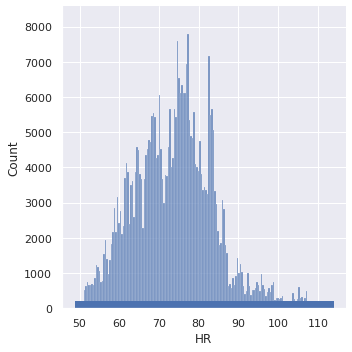

In [209]:
sns.displot(y_train, kde=False, rug=True);

In [210]:
y_train.describe()

count    369289.000000
mean         73.941824
std          10.337453
min          48.737243
25%          66.715776
50%          74.217809
75%          80.334937
max         113.752309
Name: HR, dtype: float64

1. All HR are positive values.
2. Right Sckewed, can bring in log transform to make normalized. Will check that.


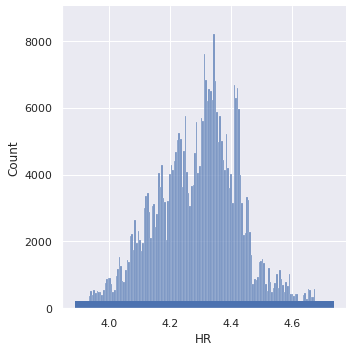

In [211]:
sns.displot(np.log(y_train), kde=False, rug=True);

## Why log?

  y = exp(log(y))

A model will perform better if the data is normally distributed. Since our HR is not normal we will make it normal by log, and say y_norm [check the values]. Train the model with y_norm, predict the y_norm for test data, then during submit take the expo of y_norm to get the yhat.


# Some basic EDA

## Drop datasetId

In [212]:
df_train['datasetId'].value_counts()

2    369289
Name: datasetId, dtype: int64

In [213]:
df_test['datasetId'].value_counts()

2    41033
Name: datasetId, dtype: int64

datasetId contains same values and it doesnot provide any additional information to the model. Hence we will drop the column in both test and train dataset.

In [214]:
df_train.drop(columns= ['datasetId'], inplace=True)
df_test.drop(columns= ['datasetId'], inplace=True)

In [215]:
df_train.condition.value_counts()

no stress        200082
interruption     105150
time pressure     64057
Name: condition, dtype: int64

In [216]:
df_test.condition.value_counts()

no stress        22158
interruption     11782
time pressure     7093
Name: condition, dtype: int64

In [217]:
df_train.drop(columns= ['uuid'], inplace=True)

In [218]:
y_id = df_test.pop('uuid')

In [219]:
df_train.head(5)

,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,SD1,SD2,sampen,higuci,condition
0,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,0.007969,2.143342,-0.856554,0.335218,11.001565,199.061782,2.139754,1.163485,no stress
1,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,0.004769,2.930855,-0.408190,-0.155286,9.170129,114.634458,2.174499,1.084711,interruption
2,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,0.008716,2.127053,0.351789,-0.656813,11.533417,118.939253,2.135350,1.176315,interruption
3,2410.357408,70.180308,1005.981659,29.290305,98.224706,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,11.800000,0.133333,-0.504947,-0.386138,0.000112,0.000494,0.017761,0.008660,0.008660,2.050988,-0.504947,-0.386138,11.119476,127.318597,2.178341,1.179688,no stress
4,1151.177330,43.918366,1421.782051,54.242160,96.720007,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,20.200000,0.200000,-0.548408,-0.154252,-0.000100,-0.002736,0.023715,0.013055,0.013055,1.816544,-0.548408,-0.154252,13.590641,87.718281,2.221121,1.249612,no stress


In [220]:
df_test.head(5)

,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,SD1,SD2,sampen,higuci,condition
0,1868.532278,76.511189,570.643114,23.366245,99.478197,2.993254,0.122565,0.521803,2442.168645,190.643094,0.005245,934.665288,939.03173,82.139495,11.801781,11.801772,6.959924,3.933333,0.133333,-0.680262,-0.233075,0.000016,0.000288,0.012933,0.004578,0.004578,2.825038,-0.680262,-0.233075,8.347898,115.862444,2.209659,1.100715,time pressure
1,568.742845,26.301350,1553.971621,71.862973,97.509212,39.694850,1.835677,2.490788,2162.409316,39.147940,0.025544,817.062380,816.33879,55.492332,20.558810,20.558768,2.699200,24.600000,0.533333,-0.034454,-0.051689,0.000040,-0.002749,0.025148,0.013921,0.013921,1.806517,-0.034454,-0.051689,14.542096,77.118903,2.186132,1.290615,no stress
2,2101.871207,75.836461,655.175895,23.639042,97.829386,14.536877,0.524497,2.170614,2771.583978,45.069921,0.022188,876.762022,894.19889,88.690820,13.853737,13.853730,6.401942,7.066667,0.533333,-0.206953,-0.589940,0.000010,-0.000172,0.015533,0.008149,0.008149,1.906180,-0.206953,-0.589940,9.799336,125.044377,2.051571,1.226663,no stress
3,5757.544433,90.562305,592.913021,9.326123,98.817806,7.093235,0.111572,1.182194,6357.550689,83.588517,0.011963,1038.640693,998.91429,213.725850,16.457194,16.454801,12.986774,10.800000,1.866667,-0.820407,0.487198,-0.000238,-0.000464,0.016882,0.007587,0.007587,2.225116,-0.820407,0.487198,11.639185,302.029812,2.080910,1.085143,time pressure
4,964.696325,70.256575,374.939530,27.305968,91.805057,33.468834,2.437457,8.194943,1373.104689,11.202647,0.089265,774.548508,778.90508,51.577855,10.273114,10.273049,5.020664,2.000000,0.066667,1.738453,-0.005082,0.000054,-0.000006,0.013479,0.007811,0.007811,1.725606,1.738453,-0.005082,7.266567,72.579248,2.068728,1.252547,interruption


In [221]:
fd_train.head()

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF
0,89df2855-56eb-4706-a23b-b39363dd605a,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055
2,c2d5d102-967c-487d-88f2-8b005a449f3e,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607
3,37eabc44-1349-4040-8896-0d113ad4811f,2410.357408,70.180308,1005.981659,29.290305,98.224706,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074
4,aa777a6a-7aa3-4f6e-aced-70f8691dd2b7,1151.177330,43.918366,1421.782051,54.242160,96.720007,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912


In [222]:
td_train.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,uuid
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,0.007969,2.143342,-0.856554,0.335218,89df2855-56eb-4706-a23b-b39363dd605a
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,0.004769,2.930855,-0.408190,-0.155286,80c795e4-aa56-4cc0-939c-19634b89cbb2
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,0.008716,2.127053,0.351789,-0.656813,c2d5d102-967c-487d-88f2-8b005a449f3e
3,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,-0.504947,-0.386138,0.000112,0.000494,0.017761,0.008660,0.008660,2.050988,-0.504947,-0.386138,37eabc44-1349-4040-8896-0d113ad4811f
4,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,-0.548408,-0.154252,-0.000100,-0.002736,0.023715,0.013055,0.013055,1.816544,-0.548408,-0.154252,aa777a6a-7aa3-4f6e-aced-70f8691dd2b7


In [223]:
hr_train.head(5)

,uuid,SD1,SD2,sampen,higuci,datasetId,condition
0,89df2855-56eb-4706-a23b-b39363dd605a,11.001565,199.061782,2.139754,1.163485,2,no stress
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,9.170129,114.634458,2.174499,1.084711,2,interruption
2,c2d5d102-967c-487d-88f2-8b005a449f3e,11.533417,118.939253,2.135350,1.176315,2,interruption
3,37eabc44-1349-4040-8896-0d113ad4811f,11.119476,127.318597,2.178341,1.179688,2,no stress
4,aa777a6a-7aa3-4f6e-aced-70f8691dd2b7,13.590641,87.718281,2.221121,1.249612,2,no stress


#Frequency domain Analysis

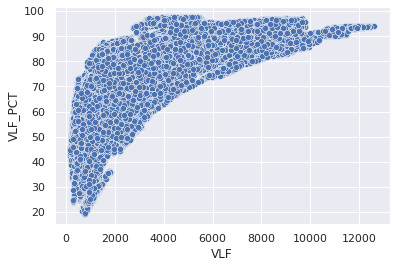

In [224]:
sns.scatterplot(x = 'VLF', y = 'VLF_PCT', data = df_train)

Some kind of transformtion is applied on VLF to get VLF_PCT 

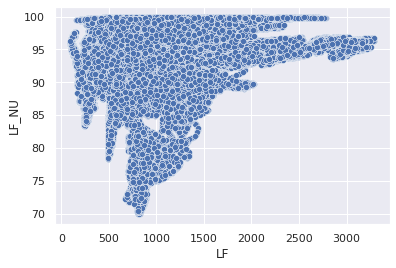

In [225]:
sns.scatterplot(x = 'LF', y = 'LF_NU', data = df_train)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


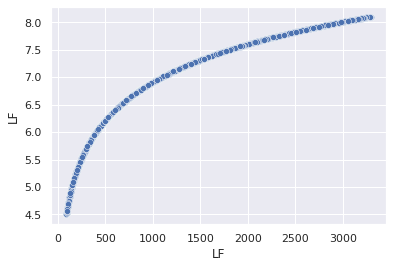

In [226]:
sns.scatterplot(df_train['LF'], np.log(df_train['LF']))

In [227]:
fd_train[['VLF_PCT','LF_PCT', 'HF_PCT']].head()

,VLF_PCT,LF_PCT,HF_PCT
0,72.203287,27.375666,0.421047
1,76.975728,22.954139,0.070133
2,51.152225,48.335104,0.512671
3,70.180308,29.290305,0.529387
4,43.918366,54.242160,1.839473


In [228]:
x = fd_train['VLF_PCT'] + fd_train['LF_PCT'] + fd_train['HF_PCT']

In [229]:
x.mean()

100.0

In [230]:
fd_train[['VLF','LF', 'HF']].head()

,VLF,LF,HF
0,2661.894136,1009.249419,15.522603
1,2314.265450,690.113275,2.108525
2,1373.887112,1298.222619,13.769729
3,2410.357408,1005.981659,18.181913
4,1151.177330,1421.782051,48.215822


In [231]:
x = fd_train['VLF'] + fd_train['LF'] + fd_train['HF']

In [232]:
x

0         3686.666157
1         3006.487251
2         2685.879461
3         3434.520980
4         2621.175204
             ...     
369284     649.351702
369285    2278.456746
369286    4331.259564
369287    2930.056129
369288    3177.292709
Length: 369289, dtype: float64

### Some Interesting features, just forget about the high corr features.!! May be thats wrong.

1. VLF_PCT = (VLF)/(VLF+HF+LF)
2. LF_PCT = (LF)/(VLF+HF+LF)
3. HF_PCT = 100 - (VLF_PCT + LF_PCT)


In [233]:
df_train.drop(columns= ['VLF_PCT','LF_PCT','HF_PCT'], inplace=True)
df_test.drop(columns= ['VLF_PCT','LF_PCT','HF_PCT'], inplace=True)

Are we going to process the raw data or computed data????

In [234]:
fd_train[['HF_NU','LF_NU']]

,HF_NU,LF_NU
0,1.514737,98.485263
1,0.304603,99.695397
2,1.049528,98.950472
3,1.775294,98.224706
4,3.279993,96.720007
...,...,...
369284,10.880317,89.119683
369285,0.357547,99.642453
369286,0.180070,99.819930
369287,3.522995,96.477005


In [235]:
x = fd_train['HF_NU'] + fd_train['LF_NU']

In [236]:
x.mean()

100.0

Interesting Formula and calculations!!!!!

1. HF_NU = HF/(HF+LF)
2. LF_NU = LF/(HF+LF)

In [237]:
df_train.drop(columns= ['HF_NU','LF_NU'], inplace=True)
df_test.drop(columns= ['HF_NU','LF_NU'], inplace=True)

In [238]:
fd_train.head()

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF
0,89df2855-56eb-4706-a23b-b39363dd605a,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055
2,c2d5d102-967c-487d-88f2-8b005a449f3e,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607
3,37eabc44-1349-4040-8896-0d113ad4811f,2410.357408,70.180308,1005.981659,29.290305,98.224706,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074
4,aa777a6a-7aa3-4f6e-aced-70f8691dd2b7,1151.177330,43.918366,1421.782051,54.242160,96.720007,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912


And ofcource 
1. TP = VLF + LF + HF
2. LF_HF = LF / HF
3. HF_LF = HF / LF

Raw data : VLF, LF, HF, all others are computed or derived data!!

The question here is are we going to use raw data or computed data.


In [239]:
df_train.drop(columns= ['TP','LF_HF', 'HF_LF'], inplace=True)
df_test.drop(columns= ['TP','LF_HF', 'HF_LF'], inplace=True)

In [240]:
hr_train.head()

,uuid,SD1,SD2,sampen,higuci,datasetId,condition
0,89df2855-56eb-4706-a23b-b39363dd605a,11.001565,199.061782,2.139754,1.163485,2,no stress
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,9.170129,114.634458,2.174499,1.084711,2,interruption
2,c2d5d102-967c-487d-88f2-8b005a449f3e,11.533417,118.939253,2.135350,1.176315,2,interruption
3,37eabc44-1349-4040-8896-0d113ad4811f,11.119476,127.318597,2.178341,1.179688,2,no stress
4,aa777a6a-7aa3-4f6e-aced-70f8691dd2b7,13.590641,87.718281,2.221121,1.249612,2,no stress


Poincare plot - RR(n) vs RR(n+1)  -> Used for time series analysis
SD1 and SD2 : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2743693/
Sample Entropy of Time Series : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5422060/
may be from time domain!!

In [241]:
td_train.head(3)

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,uuid
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,0.007969,2.143342,-0.856554,0.335218,89df2855-56eb-4706-a23b-b39363dd605a
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,0.004769,2.930855,-0.408190,-0.155286,80c795e4-aa56-4cc0-939c-19634b89cbb2
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,0.008716,2.127053,0.351789,-0.656813,c2d5d102-967c-487d-88f2-8b005a449f3e


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


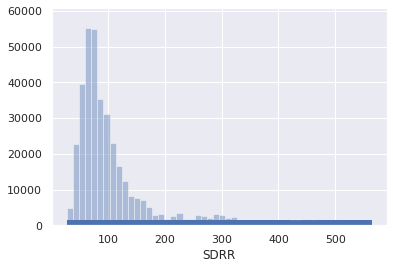

In [242]:
sns.distplot(td_train.SDRR, kde=False, rug=True)

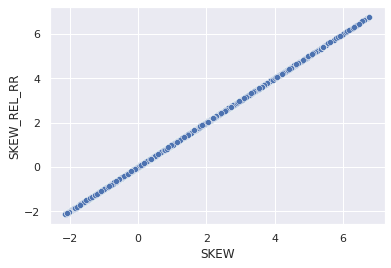

In [243]:
sns.scatterplot(x = 'SKEW', y = 'SKEW_REL_RR', data = td_train)

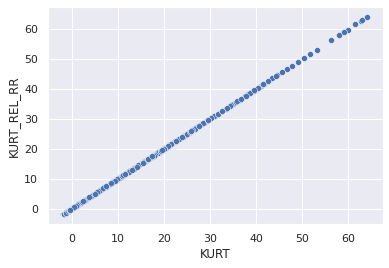

In [244]:
sns.scatterplot(x = 'KURT', y = 'KURT_REL_RR', data = td_train)

Can drop SKEW_REL_RR and KURT_REL_RR

In [245]:
df_train.drop(columns= ['SKEW_REL_RR','KURT_REL_RR'], inplace=True)
df_test.drop(columns= ['SKEW_REL_RR','KURT_REL_RR'], inplace=True)

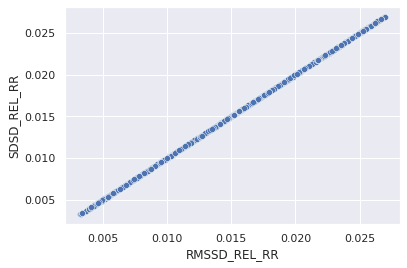

In [246]:
sns.scatterplot(x = 'RMSSD_REL_RR', y = 'SDSD_REL_RR', data = td_train)

In [247]:
df_train.drop(columns= ['SDSD_REL_RR'], inplace=True) 
df_test.drop(columns= ['SDSD_REL_RR'], inplace=True) 

In [248]:
df_train.head(3)

,VLF,LF,HF,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDRR_RMSSD_REL_RR,SD1,SD2,sampen,higuci,condition
0,2661.894136,1009.249419,15.522603,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,2.143342,11.001565,199.061782,2.139754,1.163485,no stress
1,2314.265450,690.113275,2.108525,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,2.930855,9.170129,114.634458,2.174499,1.084711,interruption
2,1373.887112,1298.222619,13.769729,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,2.127053,11.533417,118.939253,2.135350,1.176315,interruption


In [252]:
corr_matrix = df_train.corr()            
upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
high_correlation_features = [column for column in upper.columns if any(upper[column] >= 0.75)]


In [253]:
high_correlation_features

['MEDIAN_RR',
 'SDRR',
 'RMSSD',
 'SDSD',
 'SDRR_RMSSD',
 'pNN25',
 'pNN50',
 'SDRR_REL_RR',
 'RMSSD_REL_RR',
 'SD1',
 'SD2',
 'higuci']

In [254]:
df_train.drop(columns= high_correlation_features, inplace=True)
df_test.drop(columns= high_correlation_features, inplace=True)

In [255]:
df_train.head()

,VLF,LF,HF,MEAN_RR,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_RMSSD_REL_RR,sampen,condition
0,2661.894136,1009.249419,15.522603,885.157845,-0.856554,0.335218,-0.000203,-0.000179,2.143342,2.139754,no stress
1,2314.265450,690.113275,2.108525,939.425371,-0.408190,-0.155286,-0.000059,0.000611,2.930855,2.174499,interruption
2,1373.887112,1298.222619,13.769729,898.186047,0.351789,-0.656813,-0.000011,-0.000263,2.127053,2.135350,interruption
3,2410.357408,1005.981659,18.181913,881.757865,-0.504947,-0.386138,0.000112,0.000494,2.050988,2.178341,no stress
4,1151.177330,1421.782051,48.215822,809.625331,-0.548408,-0.154252,-0.000100,-0.002736,1.816544,2.221121,no stress


# Heat Map

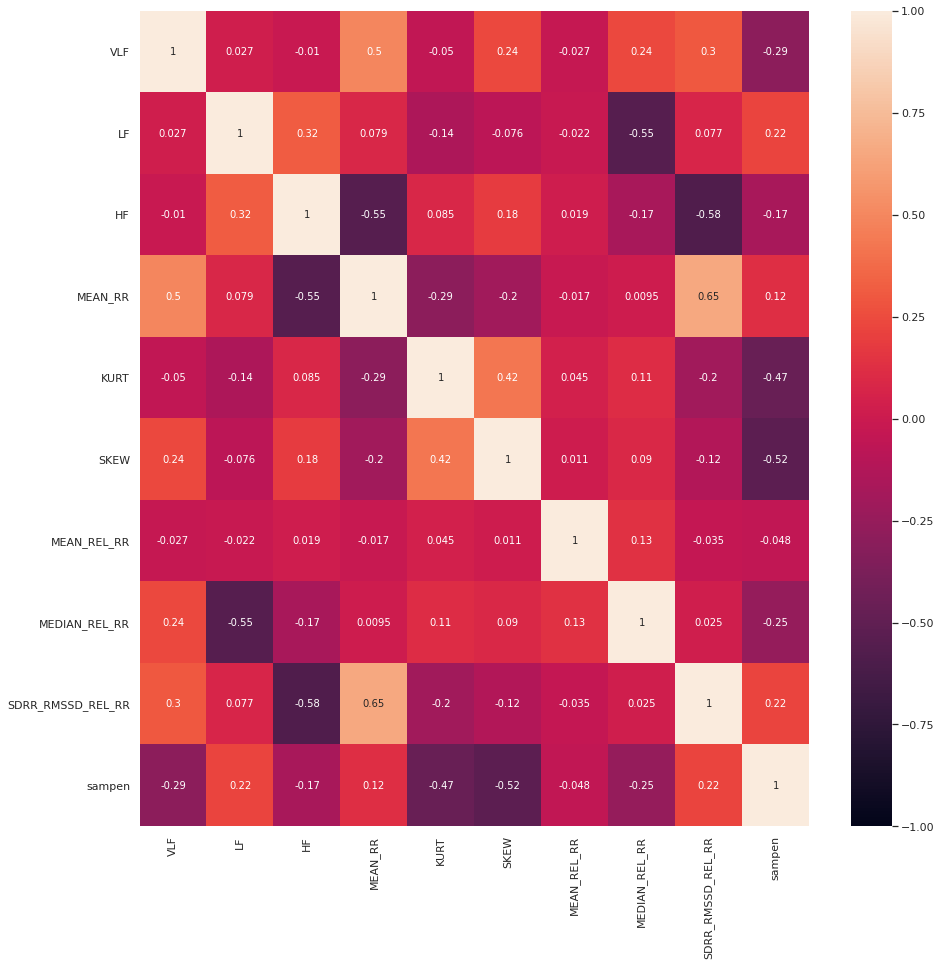

In [257]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(), annot=True, vmin = -1, vmax = 1)


# Pair Plot

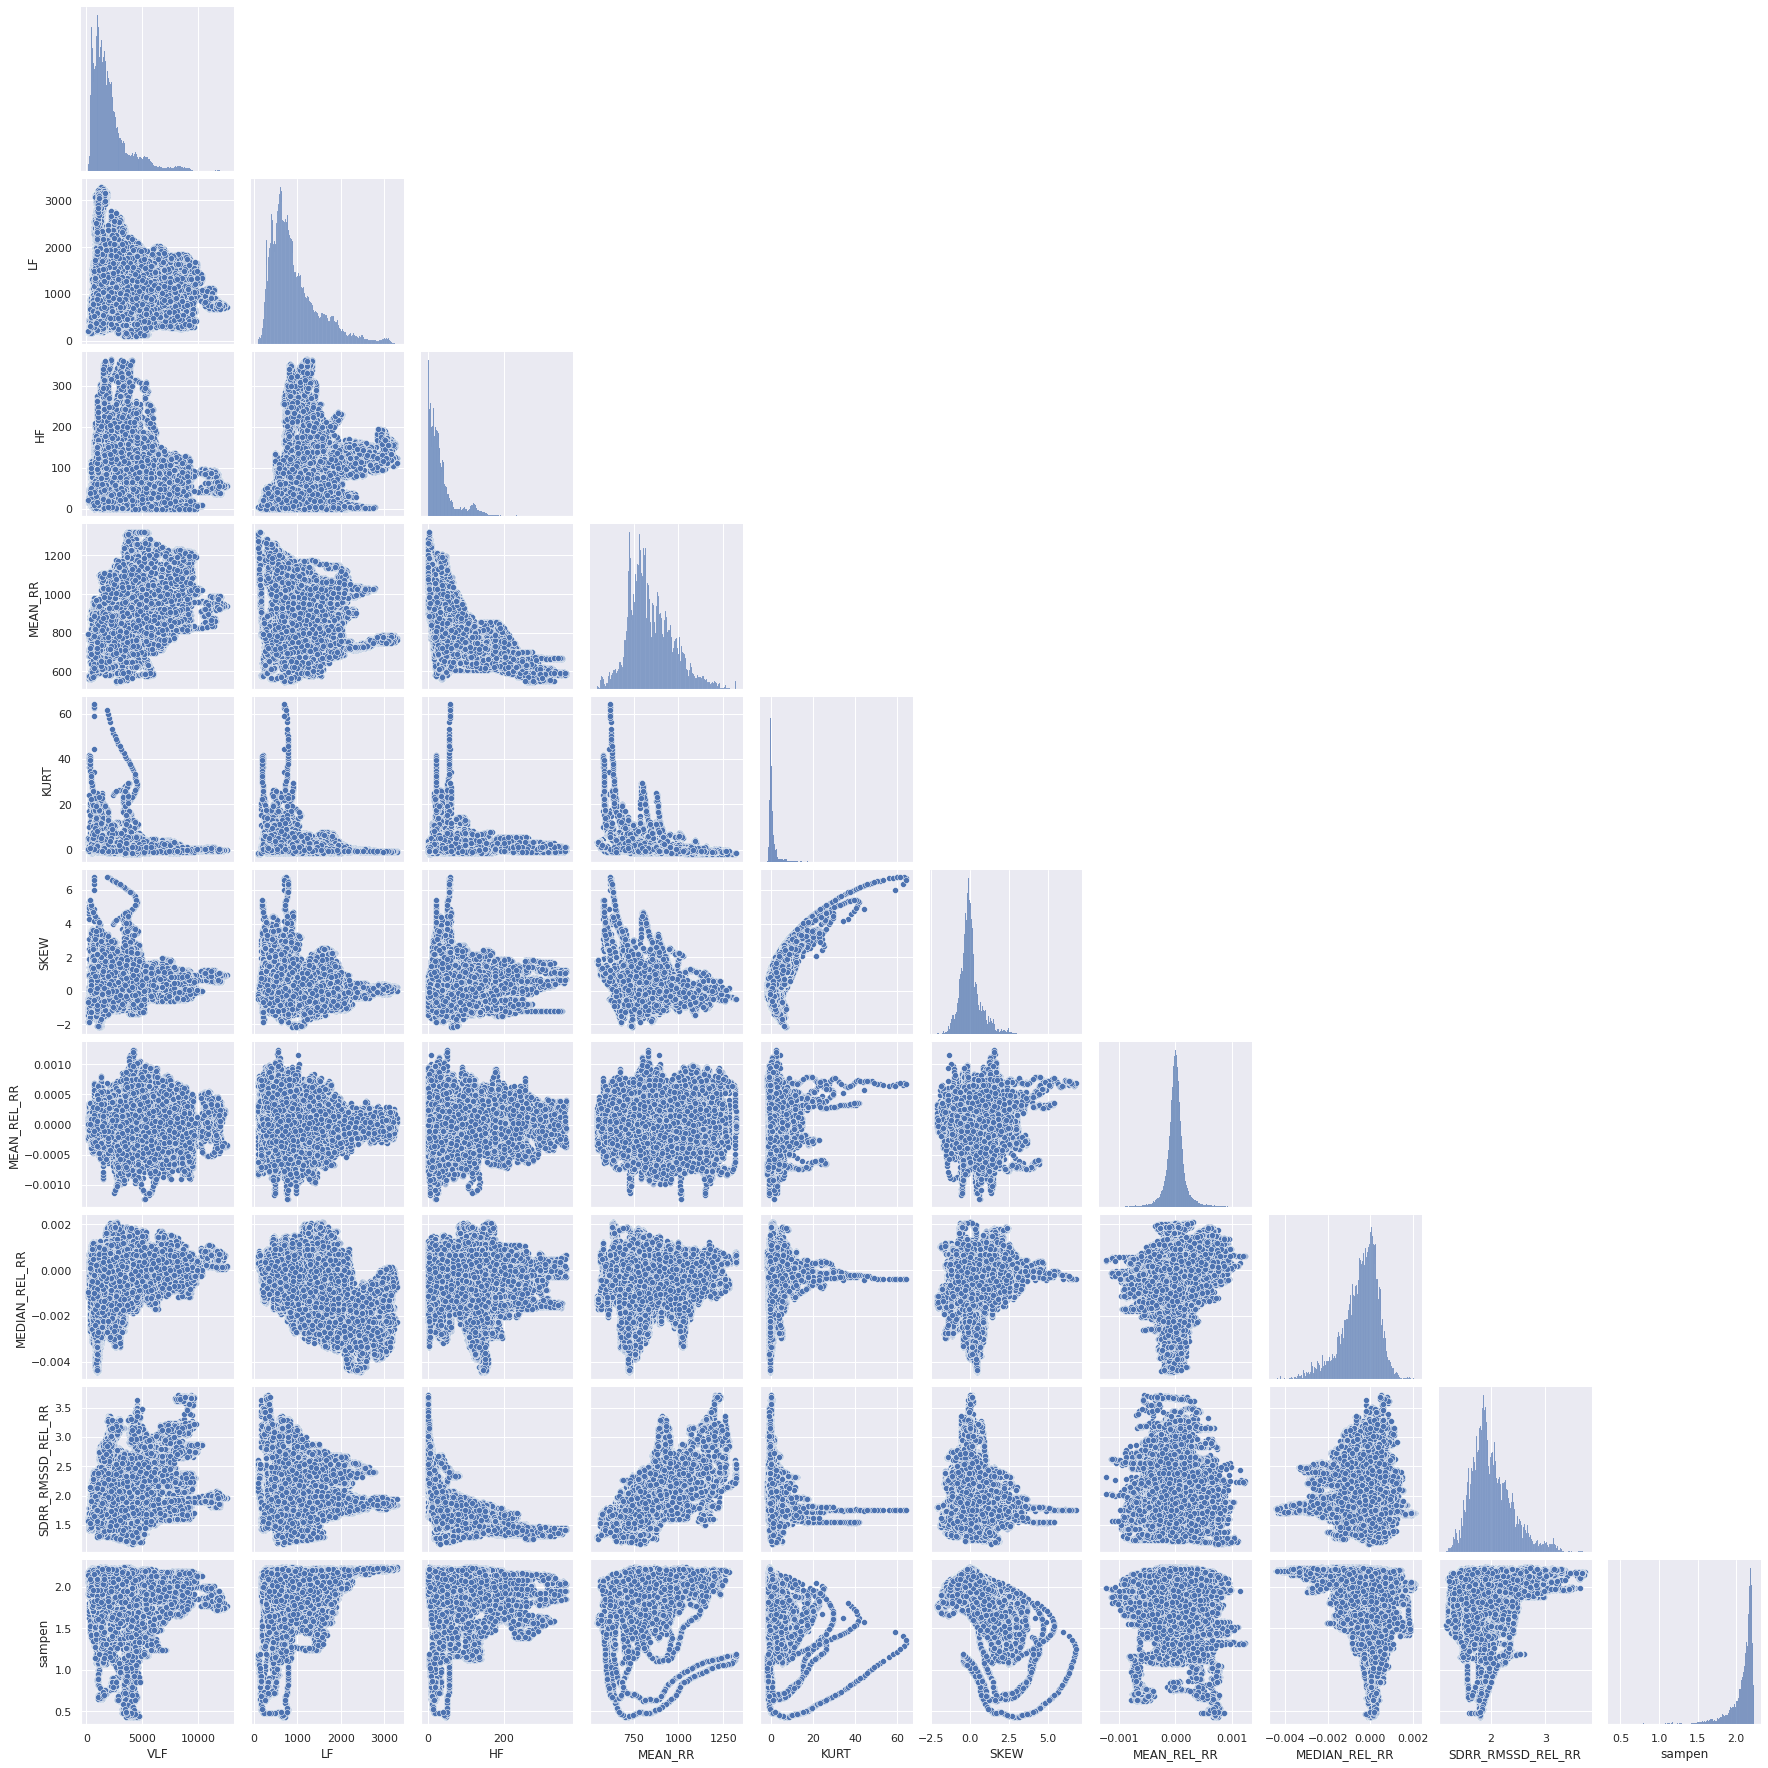

In [258]:
sns.pairplot(df_train, corner=True)